In [54]:
import pandas as pd
import openai
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
openai.api_key = os.getenv("OPENAI_API_KEY")
DATASET_PATH = './data/311_City_Service_Requests_in_2017.csv'
relevant_cols = ['OBJECTID', 'SERVICECODE', 'SERVICECODEDESCRIPTION', 'SERVICETYPECODEDESCRIPTION', 'ORGANIZATIONACRONYM', 'DETAILS']

In [10]:
data_df = pd.read_csv(DATASET_PATH, usecols=relevant_cols, index_col='OBJECTID')

In [11]:
data_df.head

<bound method NDFrame.head of            SERVICECODE             SERVICECODEDESCRIPTION  \
OBJECTID                                                    
7742223          S0031                    Bulk Collection   
7746333          EMNPV  Emergency No-Parking Verification   
7746334          S04TP                      Tree Planting   
7746335          S0441          Trash Collection - Missed   
7746336          S0181                    Illegal Dumping   
...                ...                                ...   
11717751         EMNPV  Emergency No-Parking Verification   
11717752  FEMSFIREINSP      FEMS - Fire Safety Inspection   
11717753         EMNPV  Emergency No-Parking Verification   
11717754         EMNPV  Emergency No-Parking Verification   
11717755         EMNPV  Emergency No-Parking Verification   

                                 SERVICETYPECODEDESCRIPTION  \
OBJECTID                                                      
7742223           SWMA- Solid Waste Management Adm

In [15]:
data_df['SERVICETYPECODEDESCRIPTION'].unique()

array(['SWMA- Solid Waste Management Admistration',
       'PEMA- Parking Enforcement Management Administration',
       'Urban Forrestry', 'Toa-Trans Sys Mnt-Signs',
       'Driver Vehicle Services',
       'SWMA- Solid Waste Management Administration',
       'Transportation Operations Administration', 'SNOW', 'SIOD',
       'Tru-311', 'Toa-Street & Bridge Maintenance', '311- Call Center',
       'Adjudication Services', 'DC Interagency Council on Homelessness',
       'Department of Energy and Environment', 'FEMS-Special Events',
       'HOMYDRPR- How Is My Driving Program', 'Toa- Trans Sys Mnt',
       'DOH- Department Of Health', 'Department of Transportation',
       'FEMS-Smoke Alarms',
       'Transportation Policy & Planning Administration',
       'Department of Disability Services', '311- Emergencies', 'FEMS',
       'Serve DC', 'Department of Buildings (DOB)'], dtype=object)

In [ ]:
request_set = set(data_df['SERVICECODEDESCRIPTION'].unique())
request_set.remove('311Force Reported Issues')

{'Abandoned Bicycle',
 'Abandoned Vehicle - On Private Property',
 'Abandoned Vehicle - On Public Property',
 'Alley Cleaning',
 'Alley Repair',
 'Bed Bugs',
 'Bicycle Services',
 'Bulk Collection',
 'Bus/Rail Issues',
 'Child Safety Seat Program',
 'Christmas Tree Removal-Seasonal',
 'Container Removal',
 'DC Government Information',
 'DCRA - Illegal Construction',
 'DCRA - Vacant Property Inspection',
 'DDS - Serious Medication Error',
 'DDS - Theft of Personal Property',
 'DMV - Adjudication Supervisor',
 'DMV - Appeal',
 'DMV - Copy of Ticket',
 'DMV - Driver Record Issues',
 'DMV - Driver and Vehicle Services Refund',
 'DMV - Drivers License/ID Issues',
 'DMV - Drivers License/ID Reinstatement',
 'DMV - Forms, Applications, and Manuals Request',
 'DMV - Hearings',
 'DMV - Offset Tracking',
 'DMV - Online Processing Issues',
 'DMV - Processing Center Manager',
 'DMV - Refunds - Tickets',
 'DMV - Ticket Payment Dispute',
 'DMV - Vehicle Inspection Issues',
 'DMV - Vehicle Insurance 

In [26]:
print(f"There are {len(request_set)} unique resident requests types.")

There are 119 unique resident requests types.


In [49]:
questions_by_request_type = {}

for rtype in request_set:
    prompt = (
        f"I am writing a report on 311 resident request. Generate 3 potential questions a resident might ask about the subject "
        f"request type '{rtype}'. Don't include the potential responses. Give the questions as bullet points."
    )
    
    response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "user", "content": prompt}
        ],
        temperature=0.7,
        max_tokens=200
    )
    
    generated_text = response.choices[0].message.content.strip()
    questions_by_request_type[rtype] = generated_text


In [ ]:
rows = []

for request_type, questions in questions_by_request_type.items():
    # Split questions by newline, also remove the dash (bullet point)
    question_list = [q.strip().lstrip('- ').strip() for q in questions.split('\n') if q.strip()]
    
    for question in question_list:
        rows.append((request_type, question))

question_df = pd.DataFrame(rows, columns=["request_type", "question"])

output_csv = "./data/resident_request_questions.csv"
question_df.to_csv(output_csv, index=True)


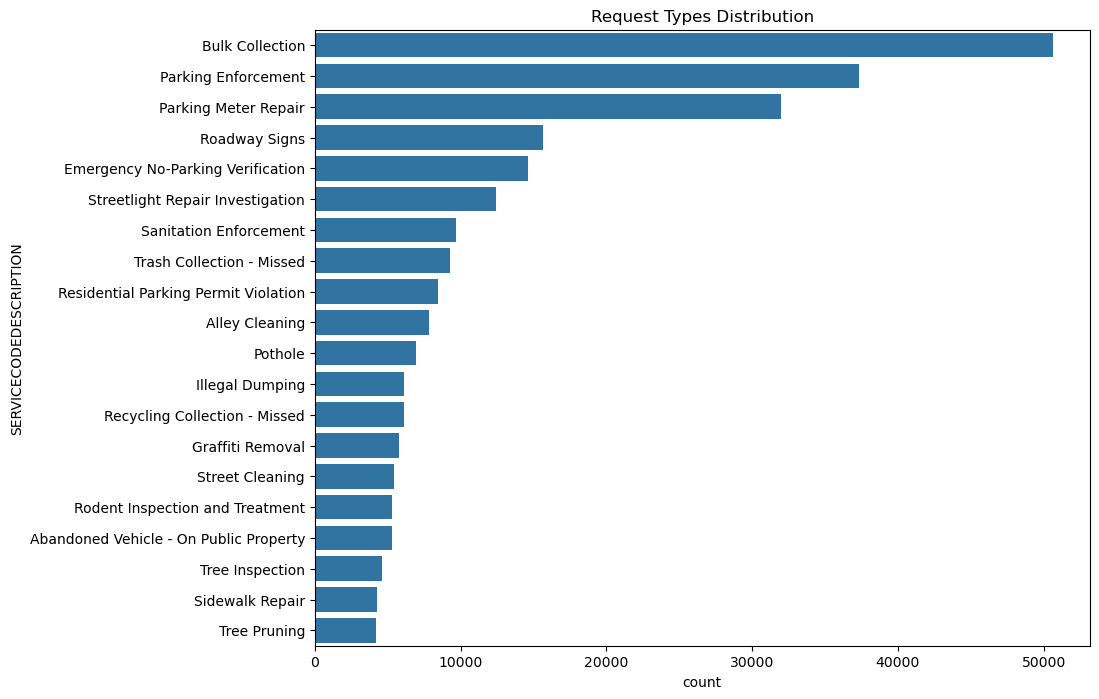

In [62]:
top_request_types = data_df['SERVICECODEDESCRIPTION'].value_counts().nlargest(20)
ordered_categories = top_request_types.index
filtered_df = data_df[data_df['SERVICECODEDESCRIPTION'].isin(ordered_categories)]

plt.figure(figsize=(10,8))
sns.countplot(data=filtered_df, y='SERVICECODEDESCRIPTION', order=ordered_categories)
plt.title(f'Request Types Distribution')
plt.show()